# KDE and RBM for Anomaly Detection

In this programming exercise, we compare in the context of anomaly detection two energy-based models: kernel density estimation (KDE) and the restricted Boltzmann machine (RBM).

In [1]:
import utils
import numpy as np
import scipy, scipy.special, scipy.spatial
import sklearn, sklearn.metrics
%matplotlib inline
import matplotlib
from matplotlib import pyplot as plt

We consider the MNIST dataset and define the class "0" to be normal (inlier) and the remain classes (1-9) to be anomalous (outlier). We consider that we have a training set `Xr` composed of 100 normal data points. The variables `Xi` and `Xo` denote normal and anomalous test data.

In [2]:
Xr, Xi, Xo = utils.getdata()

/Users/moritzgerster/opt/anaconda3/lib/python3.8/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ../torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


The 100 training points are visualized below:

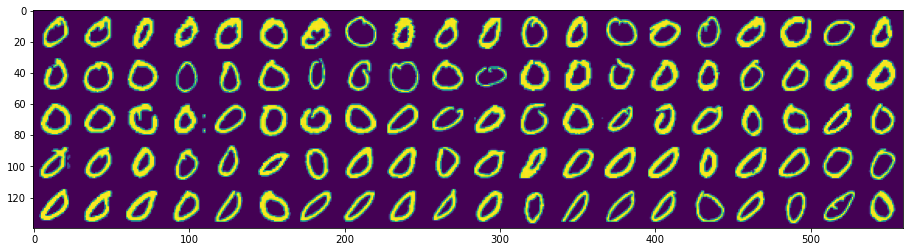

In [3]:
plt.figure(figsize=(16, 4))
plt.imshow(Xr.reshape(5, 20, 28, 28).transpose(0, 2, 1, 3).reshape(140, 560))
plt.show()

## Kernel Density Estimation (15 P)

We first consider kernel density estimation which is a shallow model for anomaly detection. The code below implement kernel density estimation.

**Task:**

 * Implement the function `energy` that returns the energy of the points `X` given as input as computed by the KDE energy function (cf. slide Kernel Density Estimation as an EBM).

In [4]:
class AnomalyModel:
    
    def auroc(self):
        Ei = self.energy(Xi)
        Eo = self.energy(Xo)
        return sklearn.metrics.roc_auc_score(np.concatenate([Ei*0 + 0, Eo*0 + 1]), np.concatenate([Ei, Eo])) 

class KDE(AnomalyModel):
    
    def __init__(self, gamma):
        self.gamma = gamma
        
    def fit(self, X):
        self.X = X
        
    def energy(self, X):
        
        D = scipy.spatial.distance.cdist(self.X, X, "sqeuclidean")
        E = -scipy.special.logsumexp(-self.gamma * D, 0)
        
        return E

The following code applies KDE with different scale parameters`gamma` and returns the performance of the resulting anomaly detection model measured in terms of area under the ROC.

In [6]:
for gamma in np.logspace(-2, 0, 10):

    kde = KDE(gamma)
    kde.fit(Xr)
    print('gamma = %5.3f  AUROC = %5.3f' % (gamma, kde.auroc()))

gamma = 0.010  AUROC = 0.957
gamma = 0.017  AUROC = 0.962
gamma = 0.028  AUROC = 0.969
gamma = 0.046  AUROC = 0.976
gamma = 0.077  AUROC = 0.981
gamma = 0.129  AUROC = 0.983
gamma = 0.215  AUROC = 0.983
gamma = 0.359  AUROC = 0.982
gamma = 0.599  AUROC = 0.982
gamma = 1.000  AUROC = 0.981


We observe that the best performance is obtained for some intermediate value of the parameter `gamma`.

## Restricted Boltzmann Machine (35 P)

We now consider a restricted Boltzmann machine composed of `100` binary hidden units ($\boldsymbol{h} \in \{0,1\}^{100}$). The joint energy function of our RBM is given by:

$$
E(\boldsymbol{x},\boldsymbol{h}) = -\boldsymbol{x}^\top \boldsymbol{a} - \boldsymbol{x}^\top W \boldsymbol{h} - \boldsymbol{h}^\top\boldsymbol{b}
$$

The model can be marginalized over its hidden units and the energy function that depends only on the input $\boldsymbol{x}$ is then given as:

$$
E(\boldsymbol{x}) = - \boldsymbol{x}^\top \boldsymbol{a} - \sum_{k=1}^{100} \log(1+\exp( \boldsymbol{x}^\top W_{:,k} + b_k))
$$

The RBM training algorithm is already implemented for you.

**Tasks:**

 * **Implement the energy function $E(\boldsymbol{x})$**
 * **Augment the function `fit` with code that prints the AUROC every 100 iterations.**

In [7]:
def sigm(t):
    return np.tanh(.5*t) * .5 + .5

def realize(t): 
    return 1. * (t > np.random.uniform(0, 1, t.shape))


class RBM(AnomalyModel):
    
    def __init__(self, X, h):
        self.mb = X.shape[0]
        self.d = X.shape[1]
        self.h = h
        self.lr = 0.1
        
        # Model parameters
        self.A = np.zeros([self.d])
        self.W = np.random.normal(0, self.d**-.25 * self.h**-.25, [self.d, self.h])
        self.B = np.zeros([self.h])
        
    def fit(self, X, verbose=False):
        
        Xm = np.zeros([self.mb, self.d])
        
        for i in np.arange(1001):
            
            # Gibbs sampling (PCD)
            Xd = X * 1.
            Zd = realize(sigm(Xd @ self.W + self.B))
            Zm = realize(sigm(Xm @ self.W + self.B))
            Xm = realize(sigm(Zm @ self.W.T + self.A))
            
            # Update parameters
            self.W += self.lr * (Xd.T @ Zd - Xm.T @ Zm) / self.mb - .01*self.W
            self.B += self.lr * (Zd.mean(axis=0) - Zm.mean(axis=0))
            self.A += self.lr * (Xd.mean(axis=0) - Xm.mean(axis=0))
            
            if verbose:
                if i % 100 == 0:
                    print(f"it {i:5d}, AUROC = {self.auroc():5.3f}")
            
        
    def energy(self, X):
        
        E = -X @ self.A - np.log(1 + np.exp(X @ self.W + self.B)).sum(1)
         
        return E

We now train our RBM on the same data as the KDE model for approximately 1000 iterations.

In [8]:
rbm = RBM(Xr, 100)
rbm.fit(Xr, verbose=True)

it     0, AUROC = 0.964
it   100, AUROC = 0.980
it   200, AUROC = 0.901
it   300, AUROC = 0.969
it   400, AUROC = 0.957
it   500, AUROC = 0.903
it   600, AUROC = 0.855
it   700, AUROC = 0.951
it   800, AUROC = 0.991
it   900, AUROC = 0.982
it  1000, AUROC = 0.952


We observe that the RBM reaches superior levels of AUROC performance compared to the simple KDE model. An advantage of the RBM model is that it learns a set of parameters that represent variations at multiple scales and with specific orientations in input space. We would like to visualize these parameters:

**Task:**

* **Render as a mosaic the weight parameters (`W`) of the model. Each tile of the mosaic should correspond to the receptive field connecting the input image to a particular hidden unit.**

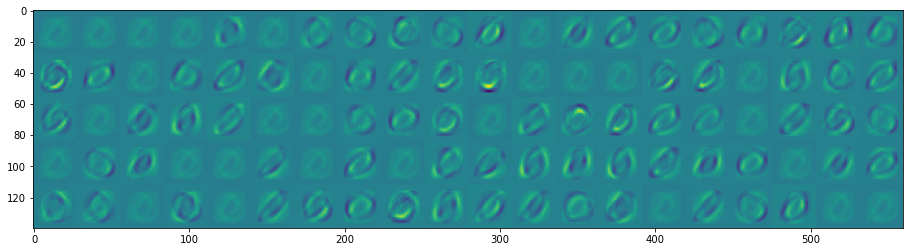

In [10]:
plt.figure(figsize=(16, 4))
plt.imshow(rbm.W.reshape(28, 28, 5, 20).transpose(2, 0 , 3, 1).reshape(28*5, 28*20));